# W207 Final Project - Facial Keypoint Recognition 
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [1]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score, RMSE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import time
import os.path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import cv2
from random import randrange
from math import sin, cos, pi
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3


np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


### Load Data 

In [2]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [3]:
# load data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


# Need to clean up a few NA's in our set


In [4]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [5]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])
# X_tmp = X_tmp / 255.0
# X = np.array([make_array(train.Image[i]) for i in range(len(train))])
X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')
# print(f'Test examples {numTestExamples}')

Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


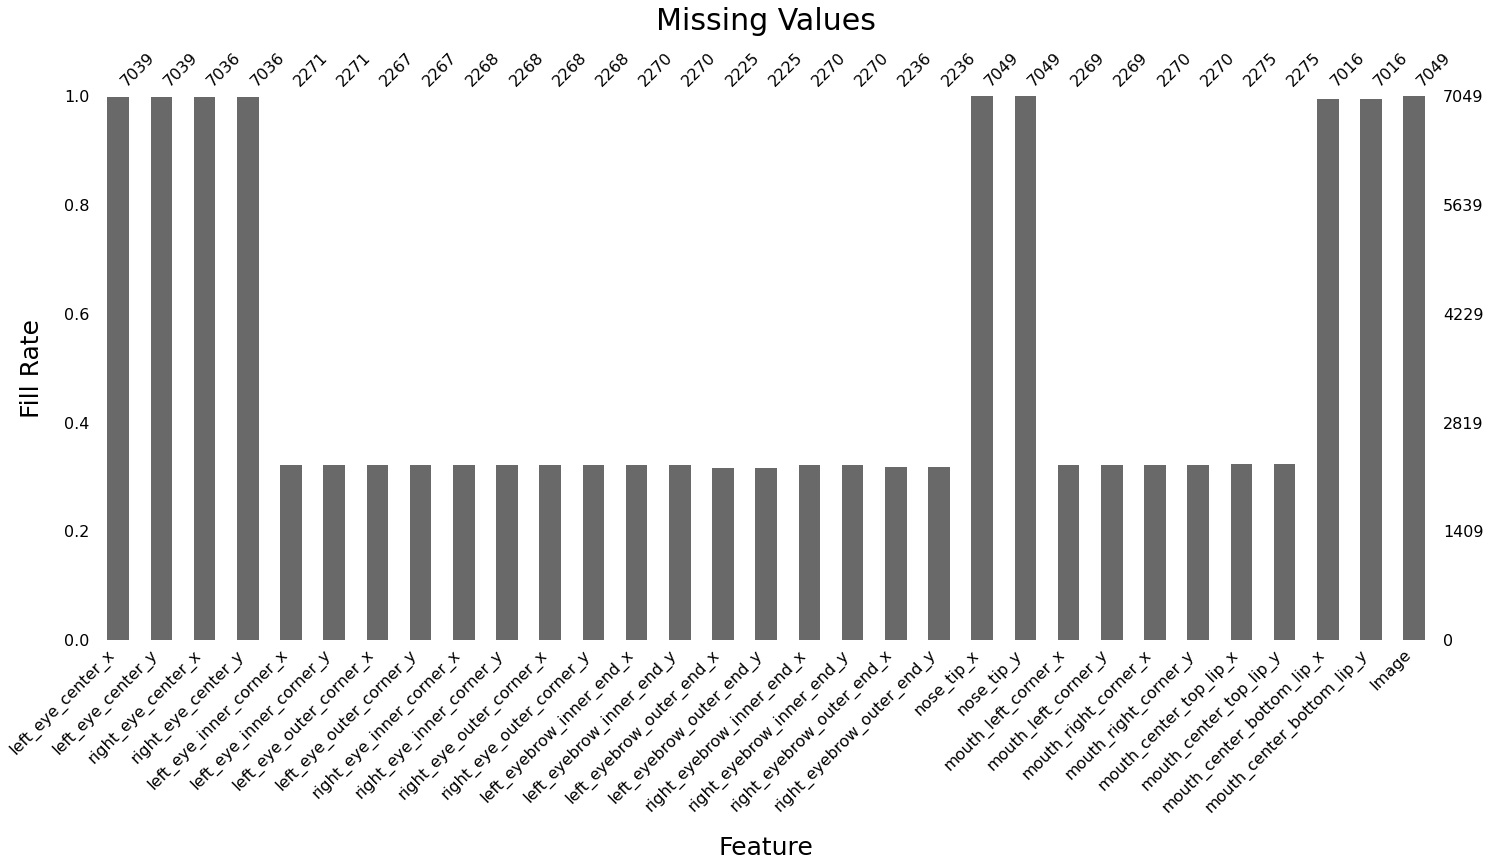

In [6]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

In [7]:
# EDA see how many na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

## EDA (Removing Missing Values)
We lose 70% of the dataset when removing NAs

In [8]:
#Checking for duplicates 
train.duplicated(subset = ['Image'])

0       False
1       False
2       False
3       False
4       False
        ...  
7044     True
7045     True
7046    False
7047    False
7048     True
Length: 7049, dtype: bool

In [9]:
#drop NAs from train and split into training and dev
train_noNA_temp = train.dropna()
dev_set = train_noNA_temp[:500]
train_noNA = train_noNA_temp[500:]

#From the complete train set, drop the rows which will be included in the dev set
cond = train['Image'].isin(dev_set['Image'])
train.drop(train[cond].index, inplace = True)

#Create a ffill set based off the training data 
train_ffill = train.fillna(method='ffill')

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_labels(label_data):
    label_data = label_data.drop(['Image'], axis=1)
    label_features = []
    for idx, features in label_data.iterrows():
        label_features.append(features)
    label_features = np.array(label_features, dtype=float)
    return label_features


#Set of full data with ffill for missing labels
train_data_ffill  = load_images(train_ffill)
train_labels_ffill = load_labels(train_ffill)


#Dataset with only no NA rows
train_data_noNA  = load_images(train_noNA)
train_labels_noNA = load_labels(train_noNA)


#Dev set for testing 
dev_data = load_images(dev_set)
dev_labels = load_labels(dev_set)


#Test images for Kaggle competition 
test_images = load_images(test)


In [10]:
print(train_noNA_temp.shape, dev_set.shape, train_noNA.shape, train.shape, train_ffill.shape)



(2140, 31) (500, 31) (1640, 31) (6549, 31) (6549, 31)


In [11]:
#Create function for showing images
def show_images(data, labels, num_examples=3):
  
  #transform data  into 2D matrix
  X2D = np.reshape(data, (-1, 96, 96))

  num = num_examples * 3
  count = 0

  #create a figure 
  fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))


  #iterate across the row of images and display one image in each of the num_examples boxes
  for n in range(num):
      ax = axes[count//num_examples, count%num_examples]
      rand = randrange(0, len(data))
      ax.imshow(X2D[rand], cmap = 'gray')
      count += 1
      for loc in range(0, len(labels[n]), 2):
          ax.plot(labels[rand][loc], labels[rand][loc+1], '*r')
      
  plt.tight_layout()
  plt.show()


View some images with labeled points.

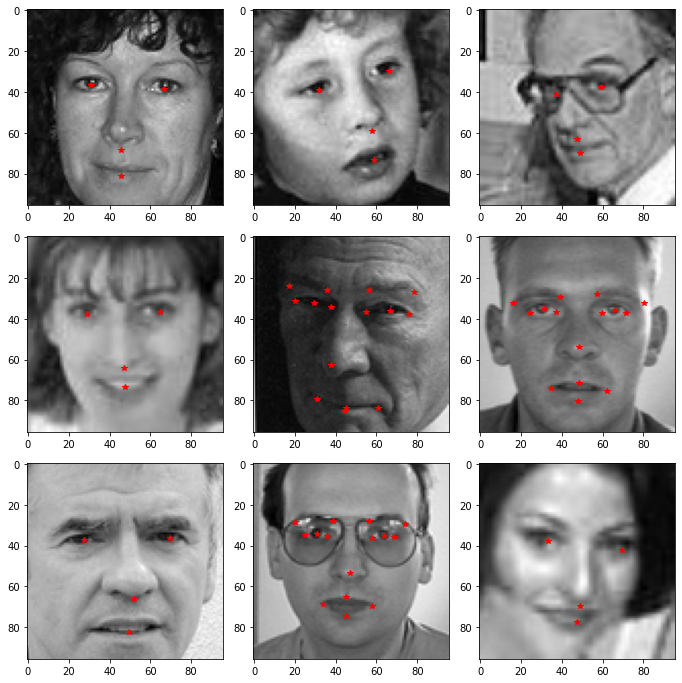

In [12]:
#explore some of the images in the training data
show_images(train_data, train_labels)

View images without missing values.

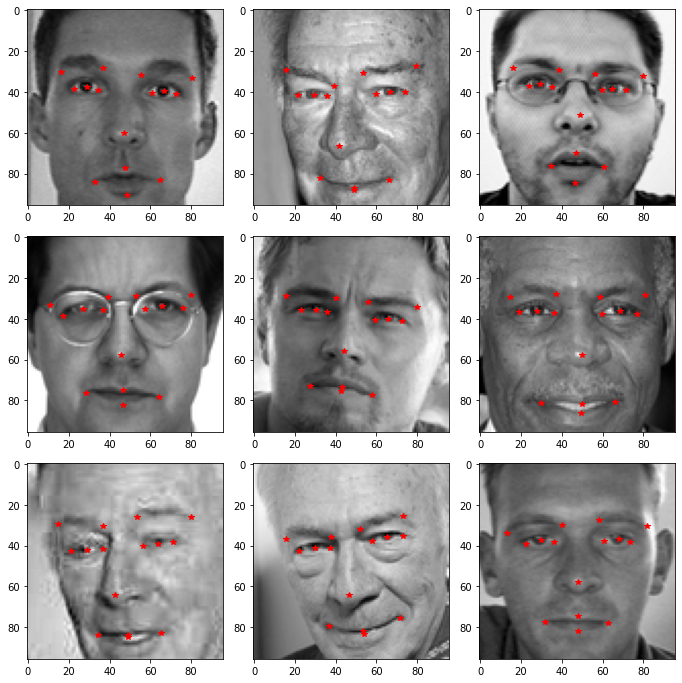

In [13]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA)

Note that images with missing values are not as accurate as fully filled records, even for the values it has filled.

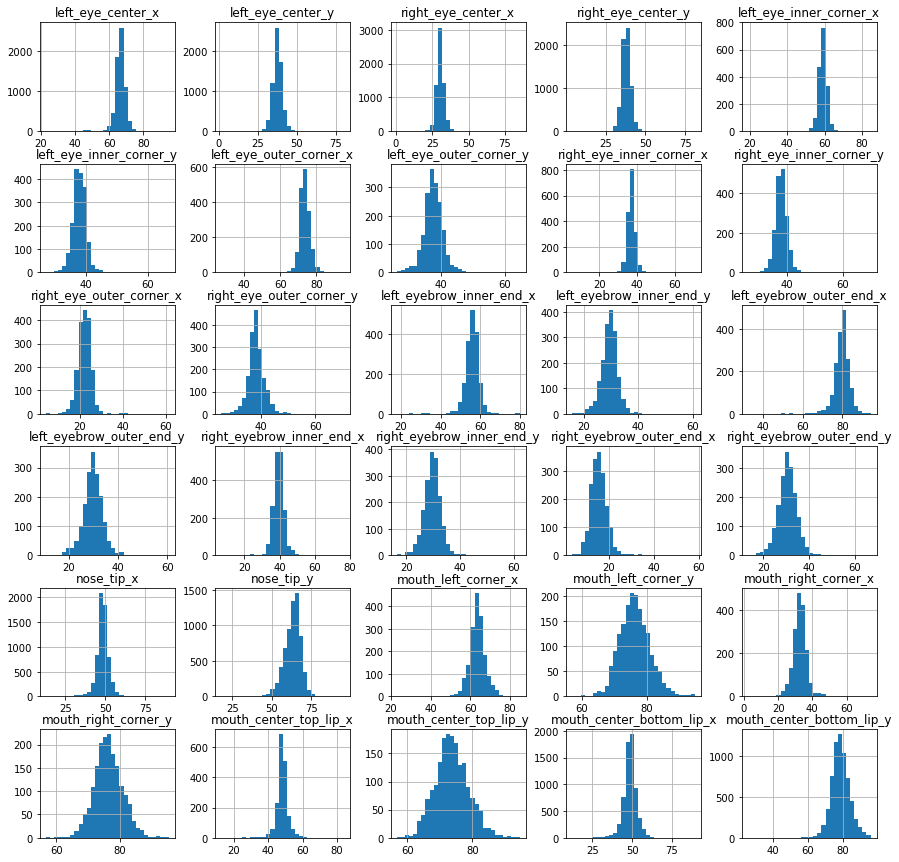

In [14]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

In [15]:
#take a look at removing outliers
# train_outliers  = train[((train['left_eye_inner_corner_x'] - train['left_eye_inner_corner_x'].mean()) / train['left_eye_inner_corner_x'].std()).abs() < 3]
# train_outliers = train[train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
# train_outliers.hist(bins = 30, figsize=(15,15))
# plt.show()

#create df for noNA data to do the same analysis as above
# tempdf = pd.DataFrame(train_labels_noNA)
# tempdf.hist(bins = 30, figsize=(15,15))
# plt.show()

Use the next two cells if you want to explore the dev data to make sure it's clean as well

In [16]:
#tempdf = pd.DataFrame(dev_labels_noNA)

In [17]:
#tempdf.hist(bins = 30, figsize=(15,15))

In [18]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(dev_data.shape)
print(dev_labels.shape)

(1640, 96, 96, 1)
(1640, 30)
(500, 96, 96, 1)
(500, 30)


## Augmenting the Data

In [19]:
# define image augmentation functions
def rotate_augmentation(images, keypoints, angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # rotate images
            for image in images:
                rotated_image = cv2.warpAffine(image, rotation_matrix, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            rotated_images_reshaped = np.reshape(rotated_images, (-1,96,96,1))
            # rotate keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            rotated_keypoints_reshaped = np.reshape(rotated_keypoints, (-1, 30))
    return rotated_images_reshaped, rotated_keypoints_reshaped

def alter_brightness(images, keypoints, increase_factor=1.2, decrease_factor=0.6):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*increase_factor, 0.0, 1.0)    # Increased brightness & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*decrease_factor, 0.0, 1.0)    # Decreased brightness & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_brightness_images_reshaped = np.reshape(altered_brightness_images, (-1,96,96,1))
    altered_brightness_keypoints_reshaped = np.reshape(np.concatenate((keypoints, keypoints)), (-1, 30))
    return altered_brightness_images_reshaped, altered_brightness_keypoints_reshaped

def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            shift_matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, shift_matrix, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_images_reshaped = np.reshape(shifted_images, (-1,96,96,1))
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    shifted_keypoints_reshaped = np.reshape(shifted_keypoints, (-1, 30))
    return shifted_images_reshaped, shifted_keypoints_reshaped

def add_random_noise(images, keypoints, noise_factor=0.008):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, noise_factor*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    noisy_images_reshaped = np.reshape(noisy_images, (-1,96,96,1))
    return noisy_images_reshaped, keypoints

def guassian_blur(images, keypoints, kernel=(5,5)):
    blurred_images = []
    for image in images:
        dst = cv2.GaussianBlur(image, kernel, cv2.BORDER_DEFAULT)
        blurred_image = dst.reshape(96,96,1)
        blurred_images.append(blurred_image)
    blurred_images_reshaped = np.reshape(blurred_images, (-1,96,96,1))
    return blurred_images_reshaped, keypoints

In [20]:
# rotate images and keypoints
train_data_rotated, train_labels_rotated = rotate_augmentation(train_data_noNA, train_labels_noNA, [12])

# alter brightness
train_data_brightness, train_labels_brightness = alter_brightness(
                                                        train_data_noNA,
                                                        train_labels_noNA,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_shifted, train_labels_shifted = shift_images(train_data_noNA, train_labels_noNA, [12])

# add random noise
train_data_noise, train_labels_noise = add_random_noise(train_data_noNA, train_labels_noNA, 0.03)

# apply gaussian blur
train_data_blurred, train_labels_blurred = guassian_blur(train_data_noNA, train_labels_noNA, kernel=(5,5))

In [21]:
# merge all augmented data
train_data_aug = np.concatenate(
    (train_data_noNA, train_data_rotated, train_data_shifted, train_data_brightness, train_data_noise, train_data_blurred)
)

train_labels_aug = np.concatenate(
    (train_labels_noNA, train_labels_rotated, train_labels_shifted, train_labels_brightness, train_labels_noise, train_labels_blurred)
)

print(train_data_aug.shape)
print(train_labels_aug.shape)

(16267, 96, 96, 1)
(16267, 30)


# Modeling on the data

In [22]:
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1200, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (940, 9216)
label_reshape= (-1, 30)

In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

### Baseline

In [ ]:
# baseline model with NAs
model_base = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model_base.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_base.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_base.fit(train_data.reshape(train_reshape), train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_base = model_base.evaluate(dev_data.reshape(dev_reshape), dev_labels, verbose=0) 
print('Test score:', score_base[0]) 
print('Test accuracy:', score_base[1])

### Missing Value Records Removed

In [ ]:
# No NA model
model_NN_noNA1 = Sequential()
# model_NN_noNA1.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_noNA1.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_noNA1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model_NN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model_NN_noNA1.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score_NN_noNA1 = model_NN_noNA1.evaluate(dev_data_noNA.reshape(dev_noNA_reshape), dev_labels_noNA, verbose=0) 
print('Test score:', score_NN_noNA1[0]) 
print('Test accuracy:', score_NN_noNA1[1])

Because baseline performance is higher on the missing-value-removed model, and the filled values on the missing-value records are inaccurate, we will proceed with iterating on the no-na model (or maybe we will add an additional label that specifies which records had imputed values) so the model can take that into consideration.

### Convolutional Model Baseline Attempt (FFILL)

In [88]:
model_CNN_ffill1 = Sequential() 
model_CNN_ffill1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_ffill1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_ffill1.add(Dropout(0.5))
model_CNN_ffill1.add(Flatten())
model_CNN_ffill1.add(Dense(96))
model_CNN_ffill1.add(BatchNormalization())
model_CNN_ffill1.add(Activation('relu'))
model_CNN_ffill1.add(Dense(30))
 

# model_CNN_ffill1.summary()

model_CNN_ffill1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_CNN_ffill1 = model_CNN_ffill1.fit(train_data_ffill, train_labels_ffill, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_CNN_ffill1 = model_CNN_ffill1.evaluate(dev_data, dev_labels, verbose=0)
print('Test score:', score_CNN_ffill1[0]) 
print('Test accuracy:', score_CNN_ffill1[1])



Epoch 1/100
103/103 [==============================] - 24s 224ms/step - loss: nan - accuracy: 0.0014 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
103/103 [==============================] - 23s 223ms/step - loss: nan - accuracy: 1.5270e-04 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
103/103 [==============================] - 23s 222ms/step - loss: nan - accuracy: 1.5270e-04 - val_loss: nan - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
103/103 [==============================] - 23s 223ms/step - loss: nan - accuracy: 0.1095 - val_loss: nan - val_accuracy: 0.1660 - lr: 0.0010
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3991
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
103/103 [==============================] - 23s 223ms/step - loss: nan - accuracy: 0.3991 - val_loss: nan - val_accuracy: 0.1660 - lr: 0.0010
Epoch 6/100
103/103 [==============================] - 23

Text(0.5, 0.98, 'Model Metrics')

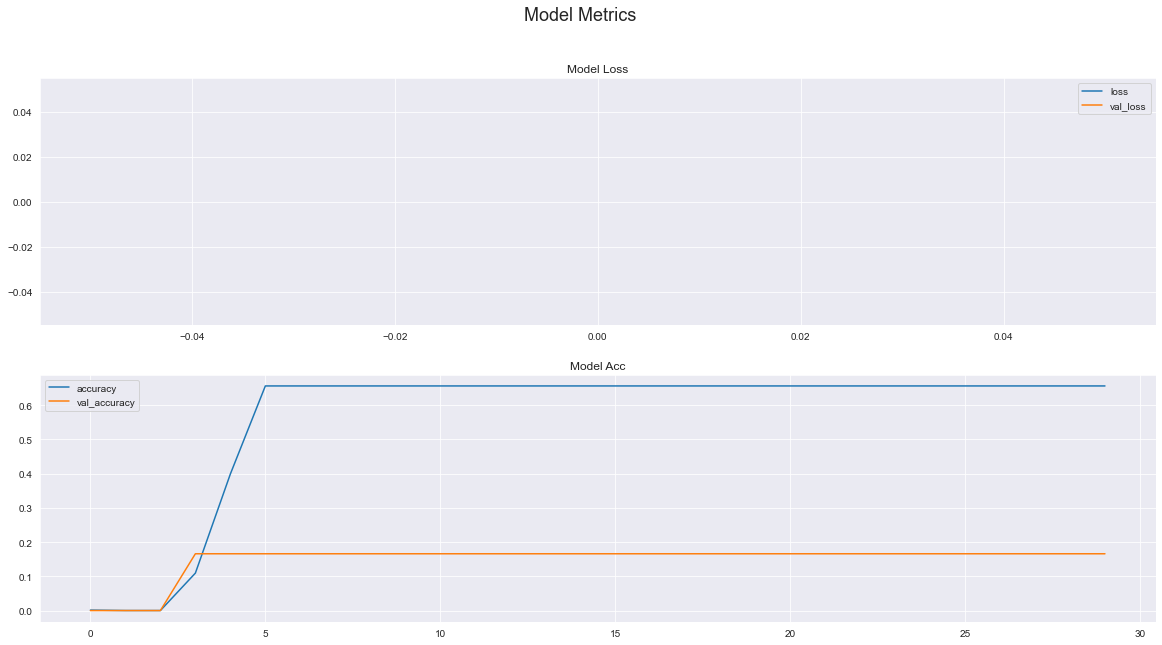

In [89]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_ffill1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Same CNN as before, but training with the noNA dataset

In [90]:
model_CNN_noNA1 = Sequential() 
model_CNN_noNA1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_noNA1.add(Dropout(0.2))
model_CNN_noNA1.add(Flatten())
model_CNN_noNA1.add(Dense(96))
model_CNN_noNA1.add(BatchNormalization())
model_CNN_noNA1.add(Activation('relu'))
model_CNN_noNA1.add(Dense(30))
 

# model_CNN_noNA1.summary()

model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_CNN_noNA1 = model_CNN_noNA1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_CNN_noNA1 = model_CNN_noNA1.evaluate(dev_data, dev_labels)
print('Test score:', score_CNN_noNA1[0]) 
print('Test accuracy:', score_CNN_noNA1[1])


Epoch 1/100
26/26 [==============================] - 7s 273ms/step - loss: 2590.6704 - accuracy: 0.0555 - val_loss: 2445.5205 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 266ms/step - loss: 2478.7507 - accuracy: 0.0976 - val_loss: 2392.9126 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 266ms/step - loss: 2349.8132 - accuracy: 0.1146 - val_loss: 2351.7744 - val_accuracy: 0.0120 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 263ms/step - loss: 2197.7390 - accuracy: 0.1287 - val_loss: 2223.3557 - val_accuracy: 0.0160 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 264ms/step - loss: 2028.8811 - accuracy: 0.1366 - val_loss: 2065.5229 - val_accuracy: 0.1820 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 264ms/step - loss: 1845.6335 - accuracy: 0.1494 - val_loss: 1902.2806 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 7/100
26/26 [=

Text(0.5, 0.98, 'Model Metrics')

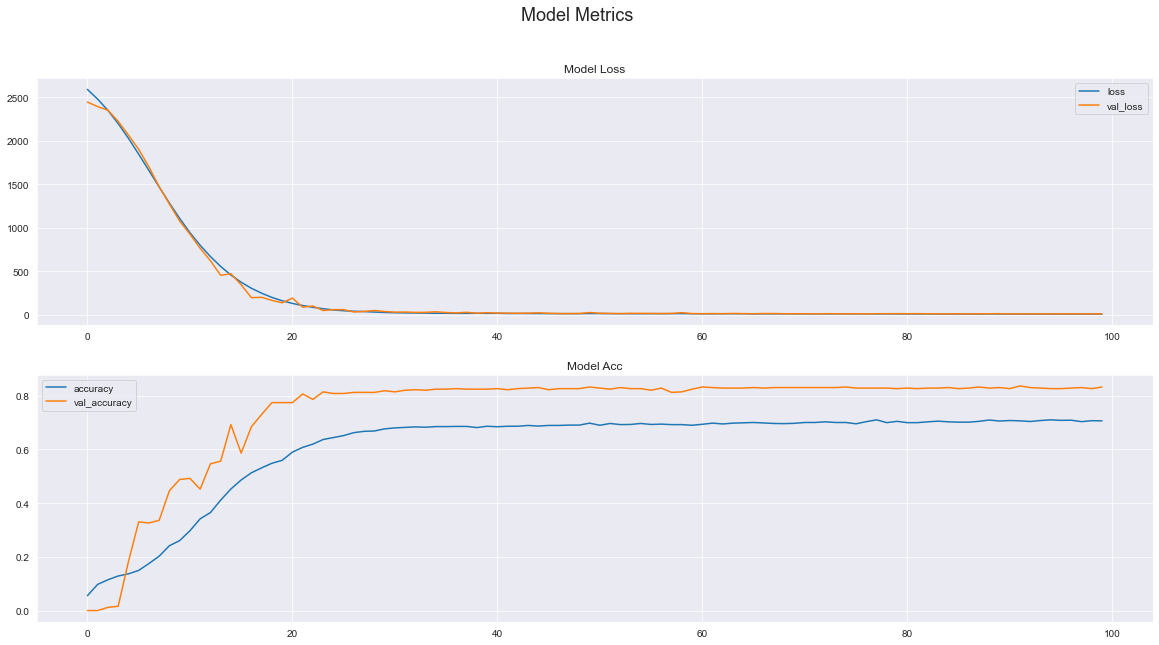

In [91]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_noNA1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Transfer learning with Resnet50: CNN with Pre-trained Resnet and one dense layer

In [94]:
model_resnet_noNA_D1 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D1.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D1.add(pretrained_model)
model_resnet_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D1.add(Dropout(0.1))
model_resnet_noNA_D1.add(Flatten())
model_resnet_noNA_D1.add(Dense(30))
model_resnet_noNA_D1.summary()

model_resnet_noNA_D1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 1, 1, 2048)        0         
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                     

In [95]:
model_resnet_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_resnet_noNA_D1 = model_resnet_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_resnet_noNA_D1 = model_resnet_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D1[0]) 
print('Test accuracy:', score_resnet_noNA_D1[1])


Epoch 1/100
26/26 [==============================] - 13s 380ms/step - loss: 292.3643 - accuracy: 0.4927 - val_loss: 679.4143 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 6s 245ms/step - loss: 12.0656 - accuracy: 0.6067 - val_loss: 42.1054 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 6s 245ms/step - loss: 9.8761 - accuracy: 0.6256 - val_loss: 229.9854 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 6s 245ms/step - loss: 7.5285 - accuracy: 0.6427 - val_loss: 208.4995 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 6s 246ms/step - loss: 6.3099 - accuracy: 0.6341 - val_loss: 144.7639 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 6s 245ms/step - loss: 6.0939 - accuracy: 0.6738 - val_loss: 114.3785 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==========================

Text(0.5, 0.98, 'Model Metrics')

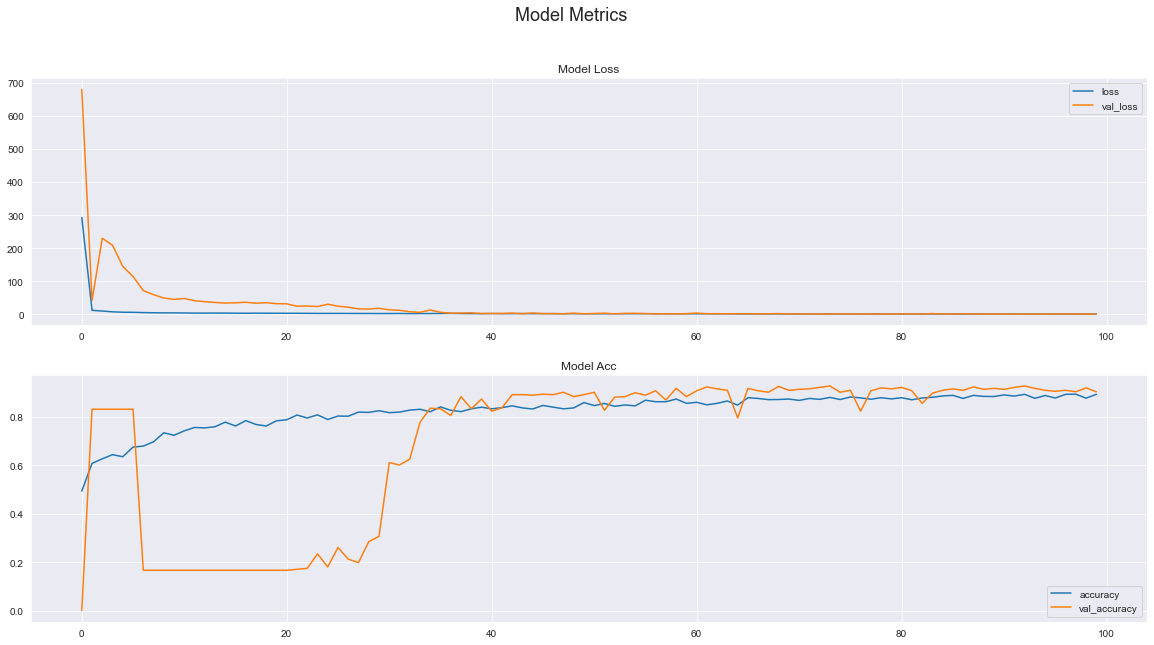

In [96]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet pretrained with two dense layers

In [97]:
model_resnet_noNA_D2 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D2.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D2.add(pretrained_model)
model_resnet_noNA_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D2.add(Dropout(0.1))
model_resnet_noNA_D2.add(Flatten())
model_resnet_noNA_D2.add(Dense(96))
model_resnet_noNA_D2.add(Dense(30))


model_resnet_noNA_D2.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 1, 1, 2048)        0         
                                                                 
 flatten_19 (Flatten)        (None, 2048)              0         
                                                     

In [98]:
model_resnet_noNA_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_resnet_noNA_D2 = model_resnet_noNA_D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_resnet_noNA_D2 = model_resnet_noNA_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D2[0]) 
print('Test accuracy:', score_resnet_noNA_D2[1])

Epoch 1/100
26/26 [==============================] - 12s 324ms/step - loss: 287.2346 - accuracy: 0.4372 - val_loss: 164718.3438 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 6s 246ms/step - loss: 13.6297 - accuracy: 0.6146 - val_loss: 782.5842 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 6s 245ms/step - loss: 10.0121 - accuracy: 0.6360 - val_loss: 397.8352 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 6s 245ms/step - loss: 8.2045 - accuracy: 0.6671 - val_loss: 215.4863 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 6s 246ms/step - loss: 7.8827 - accuracy: 0.6823 - val_loss: 125.6609 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 6s 245ms/step - loss: 6.5162 - accuracy: 0.6750 - val_loss: 73.5991 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [======================

Text(0.5, 0.98, 'Model Metrics')

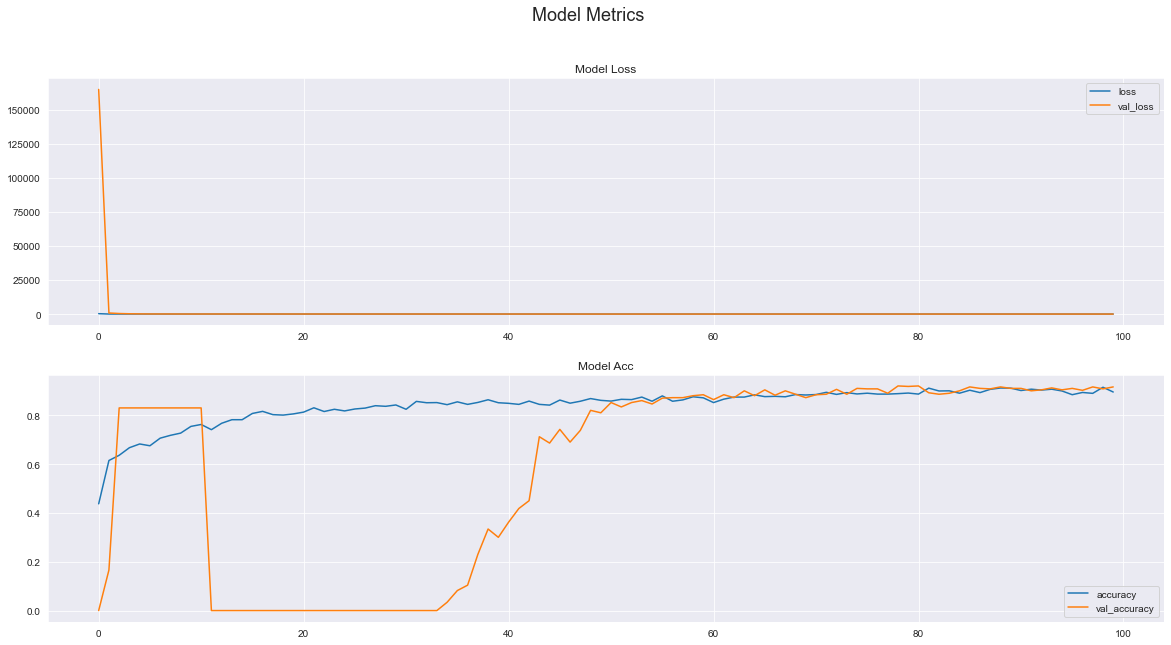

In [99]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### ResnetV2 With lots of Dense Layers


In [122]:
model_resnet_noNA_C1D4 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_noNA_C1D4.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.2))
model_resnet_noNA_C1D4.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 64)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_C1D4.add(pretrained_model)
model_resnet_noNA_C1D4.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_C1D4.add(Dropout(0.1))
model_resnet_noNA_C1D4.add(Flatten())
model_resnet_noNA_C1D4.add(Dense(1024))
model_resnet_noNA_C1D4.add(Dense(512))
model_resnet_noNA_C1D4.add(Dense(96))
model_resnet_noNA_C1D4.add(Dense(30))


model_resnet_noNA_C1D4.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 96, 96, 64)        320       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 96, 96, 64)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 96, 96, 3)         195       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                     

In [123]:
model_resnet_noNA_C1D4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_C1D4[0]) 
print('Test accuracy:', score_resnet_noNA_C1D4[1])

Epoch 1/100
26/26 [==============================] - 24s 546ms/step - loss: 445.9962 - accuracy: 0.2805 - val_loss: 1703.4091 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 8s 291ms/step - loss: 30.1093 - accuracy: 0.5939 - val_loss: 296.5736 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 266ms/step - loss: 17.4215 - accuracy: 0.6341 - val_loss: 215.2195 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 272ms/step - loss: 13.0147 - accuracy: 0.6640 - val_loss: 72.6378 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 264ms/step - loss: 11.0364 - accuracy: 0.6543 - val_loss: 28.4772 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 266ms/step - loss: 10.0564 - accuracy: 0.6555 - val_loss: 23.9539 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [===========================

Text(0.5, 0.98, 'Model Metrics')

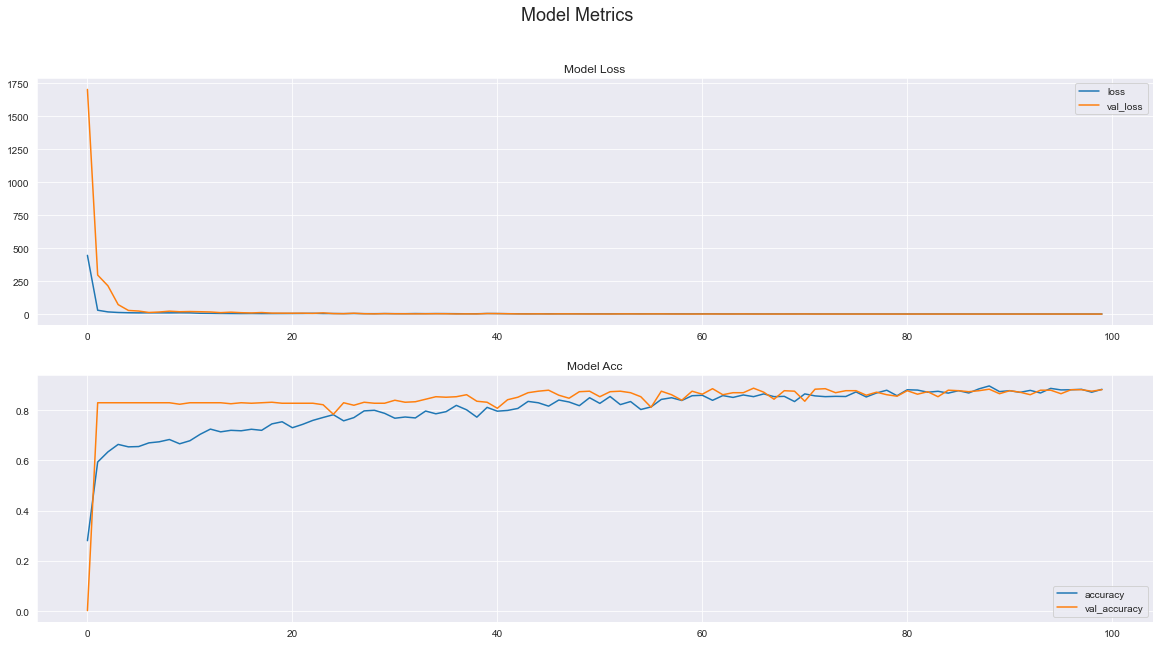

In [125]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_C1D4.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

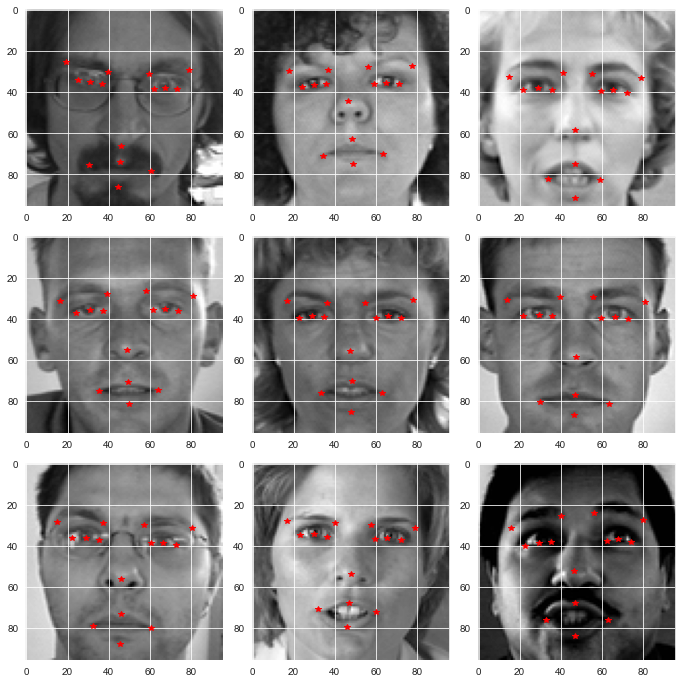

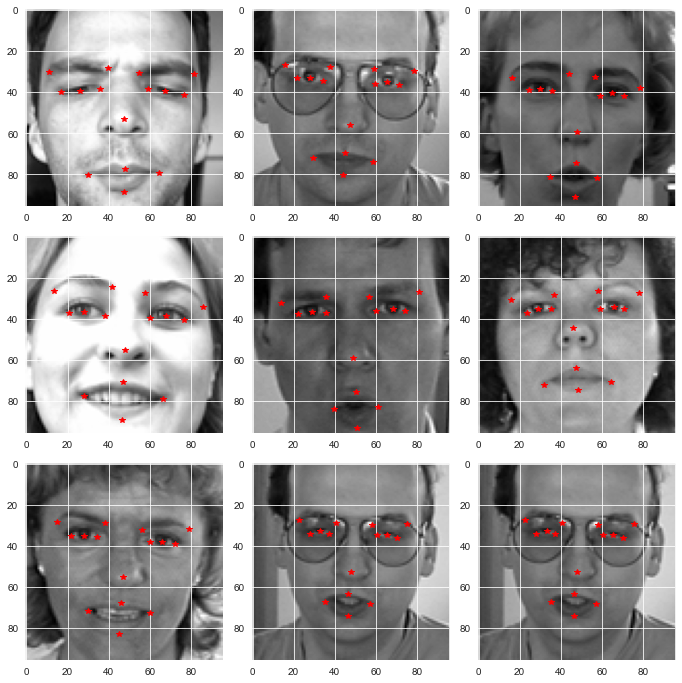

In [130]:
y_pred = model_resnet_noNA_C1D4.predict(dev_data)
show_images(dev_data, y_pred)
show_images(dev_data, dev_labels)

### Efficient Net (1 Dense Layer)

In [102]:
model_effnetB7_noNA_D1 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetB7_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_noNA_D1.add(LeakyReLU(alpha=0.1))
model_effnetB7_noNA_D1.add(pretrained_model)
model_effnetB7_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_noNA_D1.add(Dropout(0.1))
model_effnetB7_noNA_D1.add(Flatten())
model_effnetB7_noNA_D1.add(Dense(30))


model_effnetB7_noNA_D1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 1, 1, 2560)        0         
                                                                 
 flatten_21 (Flatten)        (None, 2560)              0         
                                                     

In [103]:
model_effnetB7_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_noNA_D1[0]) 
print('Test accuracy:', score_effnetB7_noNA_D1[1])

Epoch 1/100
26/26 [==============================] - 89s 2s/step - loss: 341.1995 - accuracy: 0.4970 - val_loss: 1439.1626 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 33s 1s/step - loss: 16.2628 - accuracy: 0.6537 - val_loss: 449.7756 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 95s 4s/step - loss: 13.6627 - accuracy: 0.6518 - val_loss: 103.3230 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 133s 5s/step - loss: 13.3760 - accuracy: 0.6616 - val_loss: 123.9812 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 29s 1s/step - loss: 14.5158 - accuracy: 0.6555 - val_loss: 78.3758 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 35s 1s/step - loss: 12.9915 - accuracy: 0.6561 - val_loss: 71.0735 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 43s 

Text(0.5, 0.98, 'Model Metrics')

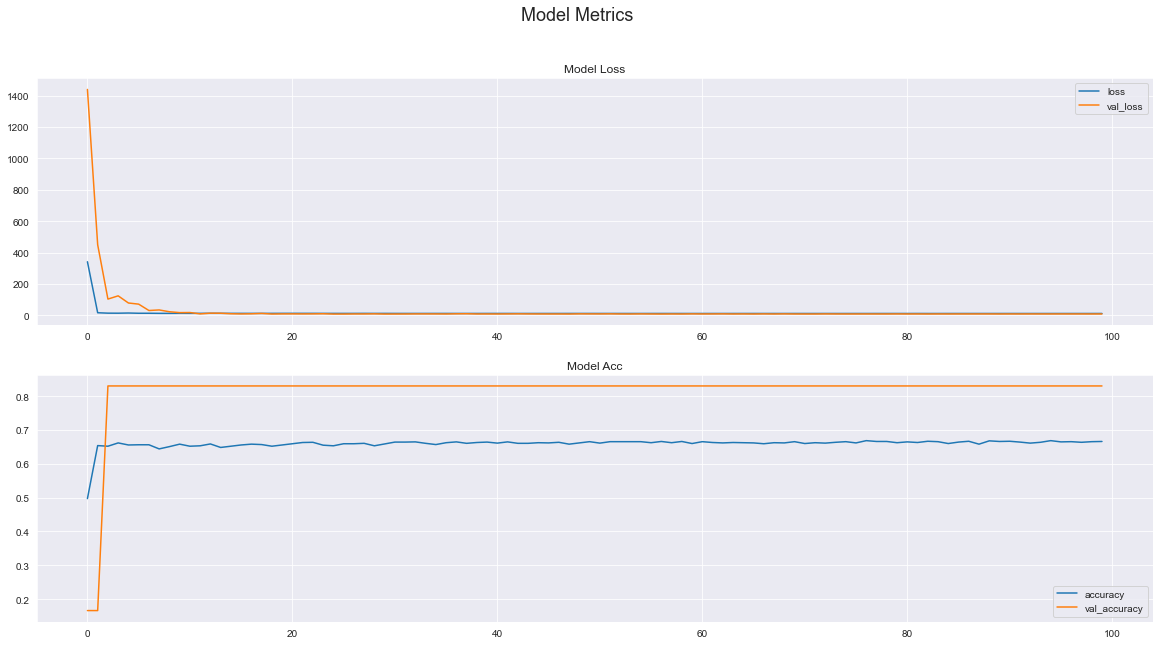

In [104]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

In [ ]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         aug_img = img_augmentation(tf.expand_dims(image, axis=0))
#         plt.imshow(aug_img[0].numpy().astype("uint8"))
#         plt.title("{}".format(format_label(label)))
#         plt.axis("off")

#Great code block for showing augmentation examples


### EfficientNet_v2B3 try number 2 (two conv, two dense, using Efficientnetv2_B3)


In [108]:
model_effnetV2B3_noNA_C2D2 = Sequential() 
pretrained_model = EfficientNetV2B3(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetV2B3_noNA_C2D2.add(Conv2D(24, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.2))
model_effnetV2B3_noNA_C2D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 24)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.1))
model_effnetV2B3_noNA_C2D2.add(pretrained_model)
model_effnetV2B3_noNA_C2D2.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetV2B3_noNA_C2D2.add(Dropout(0.1))
model_effnetV2B3_noNA_C2D2.add(Flatten())
model_effnetV2B3_noNA_C2D2.add(Dense(90))
model_effnetV2B3_noNA_C2D2.add(Dense(30))



model_effnetV2B3_noNA_C2D2.summary()

52617216/52606240 [==============================] - 5s 0us/step
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 96, 96, 24)        120       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 96, 96, 24)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 96, 96, 3)         75        
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 1, 1, 1536)      

In [109]:
model_effnetV2B3_noNA_C2D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetV2B3_noNA_C2D2[0]) 
print('Test accuracy:', score_effnetV2B3_noNA_C2D2[1])

Epoch 1/100
26/26 [==============================] - 45s 952ms/step - loss: 384.7906 - accuracy: 0.2579 - val_loss: 1420.2065 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 10s 379ms/step - loss: 13.9964 - accuracy: 0.6354 - val_loss: 1160.0442 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 8s 315ms/step - loss: 12.7362 - accuracy: 0.6646 - val_loss: 456.6062 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 9s 333ms/step - loss: 12.9386 - accuracy: 0.6665 - val_loss: 15.8116 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 8s 292ms/step - loss: 12.2452 - accuracy: 0.6652 - val_loss: 685.2131 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 8s 300ms/step - loss: 12.2859 - accuracy: 0.6659 - val_loss: 2583.2793 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
26/26 [==================

Text(0.5, 0.98, 'Model Metrics')

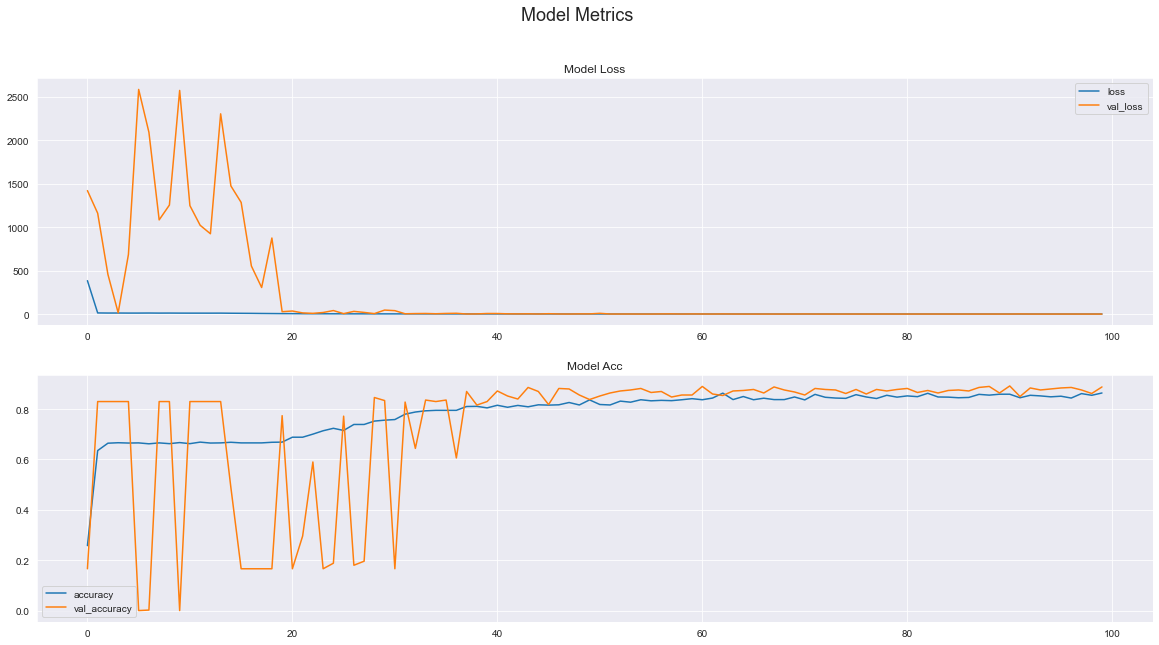

In [110]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetV2B3_noNA_C2D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet50 with Augmented Data - Transfer Learning

In [24]:
model_resnet_aug_D2 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model_resnet_aug_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same'  input_shape=(96, 96, 1)))
model_resnet_aug_D2.add(LeakyReLU(alpha=0.1))
model_resnet_aug_D2.add(pretrained_model)
model_resnet_aug_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_aug_D2.add(Dropout(0.1))
model_resnet_aug_D2.add(Flatten())
model_resnet_aug_D2.add(Dense(96))
model_resnet_aug_D2.add(Dense(30))


model_resnet_aug_D2.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 2048

In [28]:
model_resnet_aug_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_resnet_aug_D2 = model_resnet_aug_D2.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_resnet_aug_D2 = model_resnet_aug_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D2[0]) 
print('Test accuracy:', score_resnet_aug_D2[1])

Epoch 1/100
255/255 [==============================] - 57s 213ms/step - loss: 57.4723 - accuracy: 0.6301 - val_loss: 98.7872 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 53s 207ms/step - loss: 7.1277 - accuracy: 0.7328 - val_loss: 2.1354 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 53s 208ms/step - loss: 5.3541 - accuracy: 0.7773 - val_loss: 1.4956 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 53s 207ms/step - loss: 4.8141 - accuracy: 0.7993 - val_loss: 2.1634 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 53s 207ms/step - loss: 3.9111 - accuracy: 0.8164 - val_loss: 1.4873 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 53s 207ms/step - loss: 3.4791 - accuracy: 0.8220 - val_loss: 2.0818 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 7/100
255/255 [=======================

Text(0.5, 0.98, 'Model Metrics')

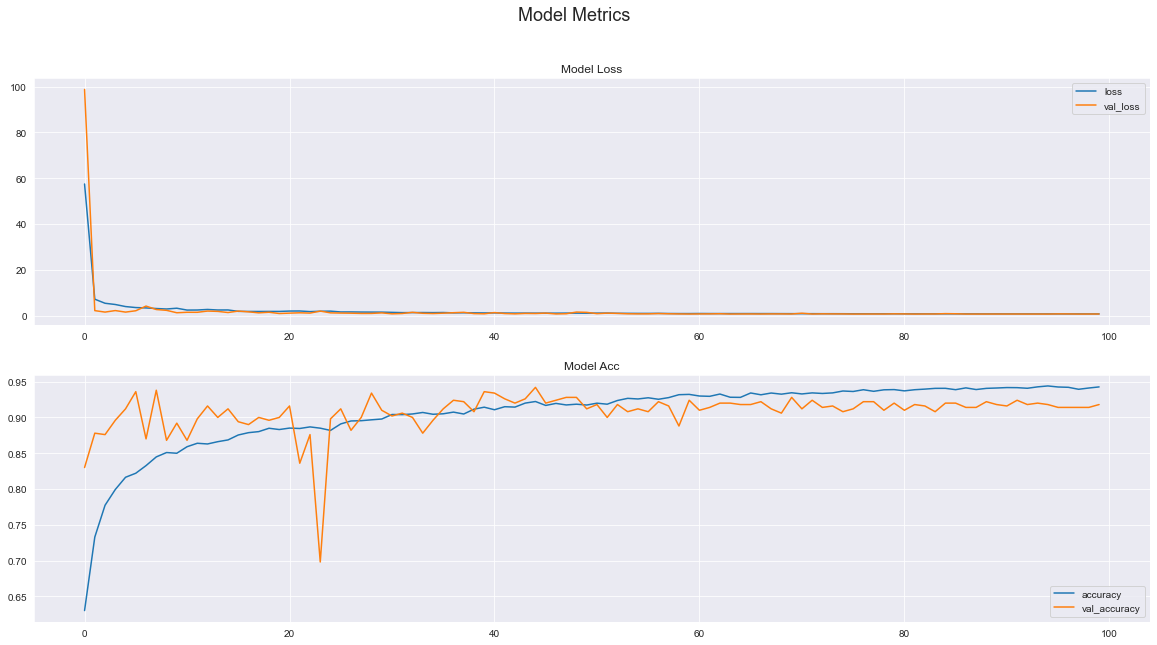

In [29]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_aug_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Efficientnet with Augmented data 

In [41]:
model_effnetB7_aug_D2 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

model_effnetB7_aug_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_aug_D2.add(LeakyReLU(alpha=0.1))
model_effnetB7_aug_D2.add(pretrained_model)
model_effnetB7_aug_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_aug_D2.add(Dropout(0.1))
model_effnetB7_aug_D2.add(Flatten())
model_effnetB7_aug_D2.add(Dense(30))


model_effnetB7_aug_D2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 2560)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 2560)        0         
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                      

In [43]:
model_effnetB7_aug_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history_effnetB7_aug_D2 = model_effnetB7_aug_D2.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
score_effnetB7_aug_D2 = model_effnetB7_aug_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_aug_D2[0]) 
print('Test accuracy:', score_effnetB7_aug_D2[1])

Epoch 1/100
255/255 [==============================] - 314s 1s/step - loss: 53.2580 - accuracy: 0.6419 - val_loss: 61.5373 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 20502s 81s/step - loss: 7.0874 - accuracy: 0.7191 - val_loss: 47.8087 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 10703s 42s/step - loss: 5.7972 - accuracy: 0.7551 - val_loss: 8.0438 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 4/100
197/255 [======================>.......] - ETA: 27:38 - loss: 4.2508 - accuracy: 0.7846

KeyboardInterrupt: 

Text(0.5, 0.98, 'Model Metrics')

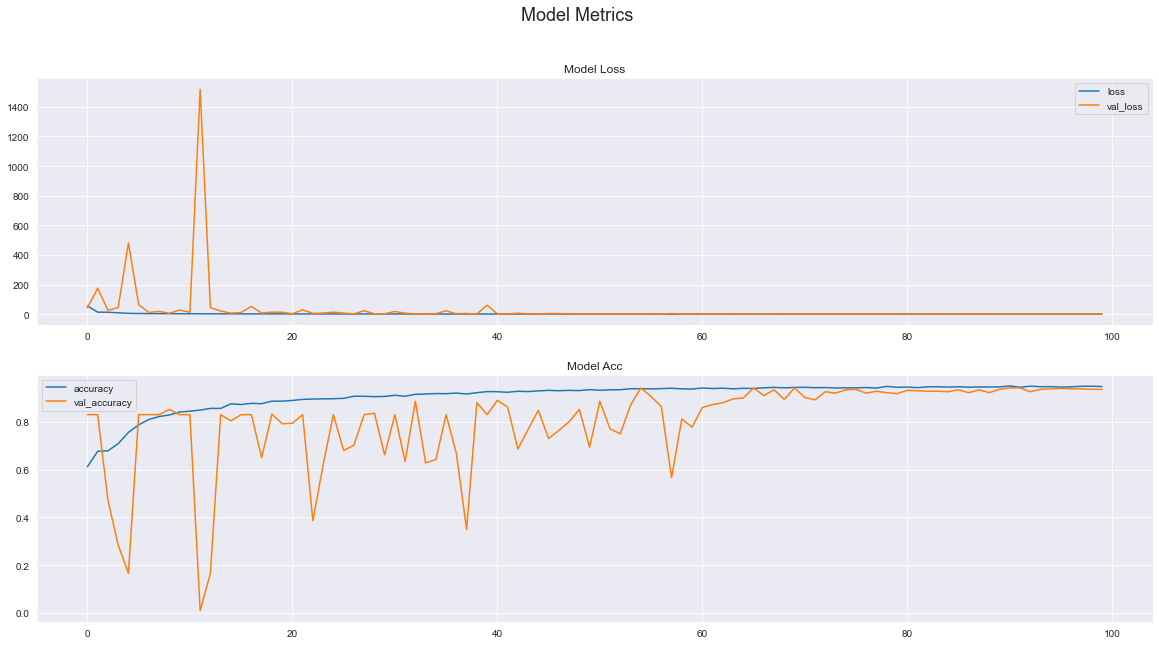

In [41]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_aug_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Jeff Heaton Transfer Learning Method

In [79]:
train_ds = train_data_aug.cache().batch(32).prefetch(buffer_size=10)
dev_ds = dev_data.cache().batch(32).prefetch(buffer_size=10)

AttributeError: 'numpy.ndarray' object has no attribute 'cache'

## Creating Submission

In [69]:
id_lookup = pd.read_csv('IdLookupTable.csv')

ImageId = list(id_lookup['ImageId']-1)
RowId = list(id_lookup['RowId'])
FeatureName = list(id_lookup['FeatureName'])
feature_list = []
for feature in FeatureName:
    feature_list.append(FeatureName.index(feature))



In [76]:
def submit(model, test_data, model_name):
    #RowId,ImageId,FeatureName,Location
    #Make Predictions 
    y_pred = model.predict(test_data)

    predictions = []
    for x,y in zip(ImageId, feature_list):
        predictions.append(y_pred[x][y])
        
    row_ids = pd.Series(RowId, name = 'RowId')
    locations = pd.Series(predictions, name = 'Location')
    
    #post processing step 
    locations = locations.clip(0.0,96.0)
    submission_result = pd.concat([row_ids,locations],axis = 1)
    submission_result.to_csv(f'{model_name}',index = False)


In [78]:
submit(model_resnet_aug_D2, test_images, 'resnet_1')